## 🎯 Goal: Sales Prediction Using Regression Models

This notebook builds and evaluates machine learning models to predict **Sales** using the feature-engineered Superstore dataset.

### 🛠️ Workflow Overview

1. **Load Data**  
   Load the cleaned and feature-engineered dataset from the previous step.

2. **Train-Test Split**  
   Split the data into training and testing sets to evaluate model performance on unseen data.

3. **Linear Regression (Baseline)**  
   - Establishes a performance benchmark  
   - Helps detect scale, collinearity, and linear patterns  
   - Interpretable coefficients

4. **Random Forest Regression**  
   - Captures non-linear relationships and feature interactions  
   - Robust to outliers and multicollinearity  
   - Generally delivers better performance in complex datasets

5. **Side-by-Side Model Comparison**  
   - Evaluate models using:
     - R² (goodness of fit)
     - RMSE (penalizes large errors)
     - MAE (average absolute error)
   - Compare results in a clean tabular format

This notebook provides a balanced trade-off between simplicity and model performance by combining interpretable and powerful modeling techniques.

In [70]:
# 📦 Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib

# 🔍 Auto-detect PROJECT_ROOT as the first parent that contains 'Data' and 'Models'
current = Path.cwd()
while not (current / "Data").exists() or not (current / "Models").exists():
    current = current.parent
PROJECT_ROOT = current

# 📁 Define key paths
FEATURE_ENGINEERED_PATH = PROJECT_ROOT / "Data" / "Processed" / "feature_engineered_superstore.csv"
MODEL_OUTPUT_DIR = PROJECT_ROOT / "Models" / "Artifacts"
METRIC_LOG_PATH = PROJECT_ROOT / "Models" / "model_metrics_log.csv"

# 📁 Ensure output directory exists
MODEL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [71]:
# Load Data
# 📥 Load the feature-engineered dataset
df = pd.read_csv(FEATURE_ENGINEERED_PATH, encoding='ISO-8859-1')
print("✅ Data loaded. Shape:", df.shape)
df.head()


✅ Data loaded. Shape: (9994, 35)


,Sales,Quantity,Discount,Profit,Order_Year,Order_Month,Order_Week,Order_Weekday,Shipping_Delay,Ship Mode_Same Day,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,261.9600,2,0.00,41.9136,2016,11,45,1,3,False,...,False,False,False,False,False,False,False,False,False,False
1,731.9400,3,0.00,219.5820,2016,11,45,1,3,False,...,False,False,False,False,False,False,False,False,False,False
2,14.6200,2,0.00,6.8714,2016,6,23,6,4,False,...,False,False,False,True,False,False,False,False,False,False
3,957.5775,5,0.45,-383.0310,2015,10,41,6,7,False,...,False,False,False,False,False,False,False,False,False,True
4,22.3680,2,0.20,2.5164,2015,10,41,6,7,False,...,False,False,False,False,False,False,False,True,False,False


In [72]:
# Define Features (X) and Target (y)
# 🎯 Define target and features
target = 'Sales'
X = df.drop(columns=[target])
y = df[target]

print("✅ Feature matrix shape:", X.shape)
print("✅ Target variable shape:", y.shape)


✅ Feature matrix shape: (9994, 34)
✅ Target variable shape: (9994,)


In [73]:
# ✂️ Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Training samples: {X_train.shape[0]} | Testing samples: {X_test.shape[0]}")


✅ Training samples: 7995 | Testing samples: 1999


In [74]:
# 📈 Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 🔍 Predict
y_pred_lr = lr_model.predict(X_test)


In [75]:
# 🌲 Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 🔍 Predict
y_pred_rf = rf_model.predict(X_test)


In [76]:
# 📊 Define evaluation function (version-independent)
def evaluate_model(y_true, y_pred):
    return {
        "R²": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),  # manually compute RMSE
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# 📋 Collect metrics for both models
metrics = pd.DataFrame({
    "Linear Regression": evaluate_model(y_test, y_pred_lr),
    "Random Forest": evaluate_model(y_test, y_pred_rf)
})

# 🪄 Format output
metrics = metrics.T.round(3)
metrics


,R²,RMSE,MAE
Linear Regression,0.038,753.649,199.070
Random Forest,0.591,491.690,85.937


In [77]:
# 💾 Save trained models

import joblib
joblib.dump(lr_model, MODEL_OUTPUT_DIR / "linear_regression_model.pkl")
joblib.dump(rf_model, MODEL_OUTPUT_DIR / "random_forest_model.pkl")
print("✅ Models saved to:", MODEL_OUTPUT_DIR)


✅ Models saved to: /Users/nastaran/DSI_Project/C6_ML5/Models/Artifacts


In [78]:
# 🧾 Save evaluation metrics to CSV
metrics["Model"] = metrics.index
metrics["Notebook"] = "03_model_training"
metrics["Version"] = "v1"

# Append to CSV if it exists
if METRIC_LOG_PATH.exists():
    existing = pd.read_csv(METRIC_LOG_PATH)
    combined = pd.concat([existing, metrics], ignore_index=True)
    combined.to_csv(METRIC_LOG_PATH, index=False)
else:
    metrics.to_csv(METRIC_LOG_PATH, index=False)

print("📊 Metrics logged to:", METRIC_LOG_PATH)


📊 Metrics logged to: /Users/nastaran/DSI_Project/C6_ML5/Models/model_metrics_log.csv


Features Importance:

Profit: 0.832
Discount: 0.034
Sub-Category_Supplies: 0.023
Quantity: 0.020
Order_Week: 0.010
Category_Office Supplies: 0.008
Shipping_Delay: 0.008
Order_Weekday: 0.007
Sub-Category_Tables: 0.007
Sub-Category_Chairs: 0.006
Order_Month: 0.005
Sub-Category_Storage: 0.005
Order_Year: 0.005
Sub-Category_Machines: 0.004
Sub-Category_Bookcases: 0.004
Category_Technology: 0.003
Segment_Corporate: 0.003
Region_West: 0.003
Region_East: 0.002
Sub-Category_Phones: 0.002


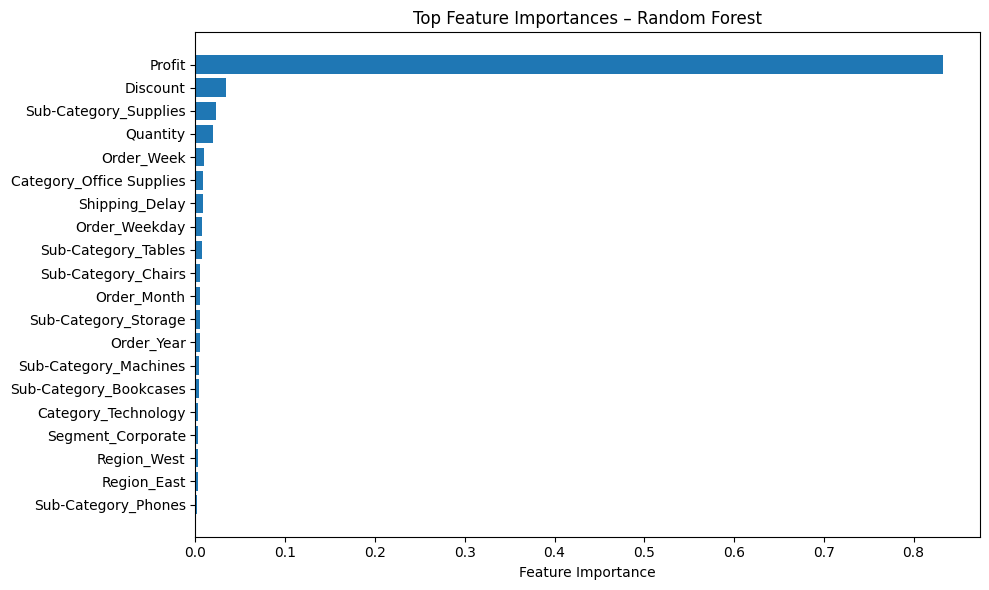

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# 🧠 Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = X.columns

# 🧾 Create a DataFrame for sorting and display
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 📋 Print the Top 20 Most Important Features
top_n = 20
top_features = importance_df.head(top_n)
print("Features Importance:\n")
for i, row in top_features.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

# 📊 Plot top N most important features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

